In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

<center>

# <span style="color:blue;">File slurm</span>

<center>

Per effettuare delle simulazioni su indaco è necessario confrontarsi con un sistema di coda. In particolare, una volta effettuato il submit del job, sarà tale sistema a gestire il processo di esecuzione. Le informazioni vengono fornite al sistema di coda mediante un file, di estensione .slurm. Di seguito riporto una versione funzionante di un file slurm: \
\
\
\
!/bin/bash

#SBATCH -o /gpfs/home/users/filippo.negrini.stud/Desktop/Fargo3D/myjob.%j.%N.out

#SBATCH -D /gpfs/home/users/filippo.negrini.stud/Desktop/Fargo3D

#SBATCH -J InnerAnti

#SBATCH -p light

#SBATCH --nodes=1

#SBATCH --ntasks-per-node=30

#SBATCH --get-user-env

#SBATCH --mail-type=end

#SBATCH --mem=8000mb

#SBATCH --mail-user=filippo.negrini@studenti.unimi.it

#SBATCH --time=02:00:00

#SBATCH --account=evaluation

module load open/mpi4.1.0openib

export PATHMPIRUN=/gpfs/software/Spack/opt/spack/linux-centos7-broadwell/gcc-10.2.0/openmpi-4.1.0-7b2qfjnxzfmwmsqrqh3gpbejanghnj7g/bin/

$PATHMPIRUN/mpirun --bind-to hwthread --display-map --map-by node -x MXM_RDMA_PORTS=mlx4_0:1 -mca btl_openib_if_include mlx4_0:1 ./fargo3d /gpfs/home/users/filippo.negrini.stud/Desktop/Fargo3D/setups/personale/personale.par

<center>

# <span style="color:blue;">Efficienza della parallelizzazione</span>

<center>

L'eseguibile ./fargo3d può essere costruito sequenziale oppure parallelizzato. Nel caso sequenziale, l'intera griglia è gestita dal singolo processore sul quale viene eseguito il programma. Nel caso parallelo la griglia viene divisa in sotto-griglie in modo tale da andare a ridurre le zone di contatto (quelle in cui è necessario scambiare informazioni fra sotto-griglie differenti): ogni sotto-griglia è a carico di un processore specifico. Vogliamo ora capire quale sia la configurazione più efficiente: per fare questo eseguo il programma su un numero diverso di processori e vedo il tempo impiegato:

- 1 processore: circa un ora

- 2 processori: 29 min 01 s

- 4 processori: 15 min 53 s

- 6 processori: 11 min 26 s

- 8 processori: 8 min 48 s

- 10 processori: 6 min 17 s

- 16 processori: 4 min 05 s

- 20 processori: 3 min 29 s

- 30 processori: 2 min 51 s

- 40 processori: 3 min 26 s (due nodi, ognuno ha 20 processi)

- 60 processori: 2 min 31 s (due nodi, ognuno ha 30 processi)

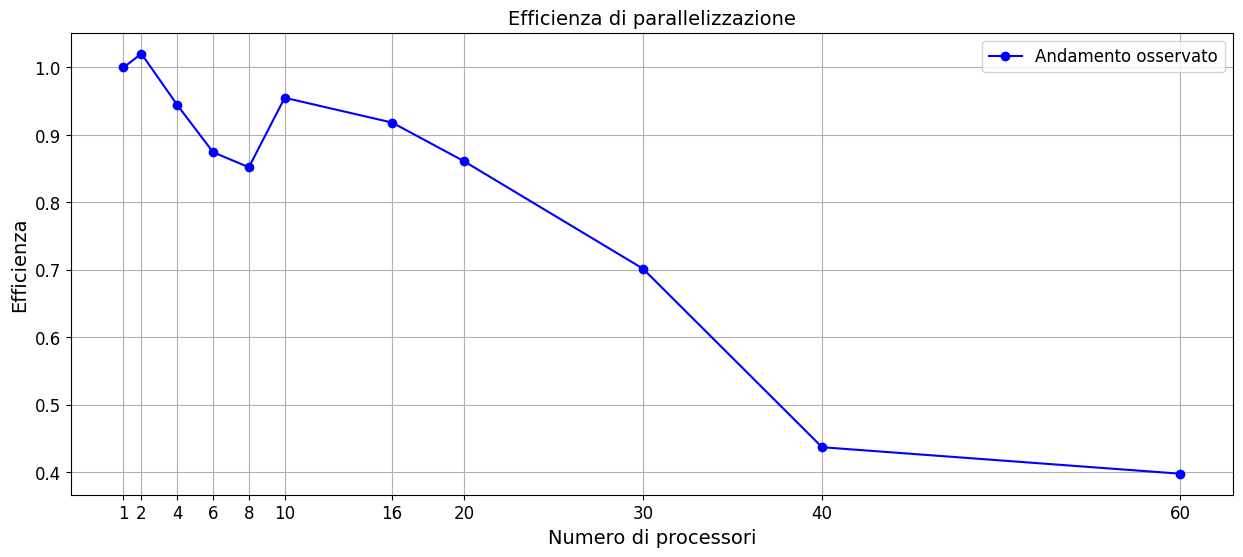

In [8]:
x = np.array([1, 2, 4, 6, 8, 10, 16, 20, 30, 40, 60])
y = np.array([1, 0.49, 0.2647, 0.1906, 0.1467, 0.1047, 0.06806, 0.05806, 0.0475, 0.0572, 0.0419])
y_teo = 1/x

plt.figure(figsize=(15, 6))
plt.plot(x, y_teo/y, color = 'blue', marker = 'o', label = 'Andamento osservato')
plt.xticks(x, ['1', '2', '4', '6', '8', '10', '16', '20', '30', '40', '60'])
plt.xlabel('Numero di processori', fontsize = 14)
plt.ylabel('Efficienza', fontsize = 14)
plt.title('Efficienza di parallelizzazione', fontsize = 14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc = 'best', fontsize = 12)
plt.show()


Notiamo come inizialmente le due curve siano praticamente sovrapposte, ossia il tempo di esecuzione del programma scala come ci aspetteremmo. Al di sopra dei 20 cores tuttavia la distribuzione osservata e quella teorica si separano nettamente: per quel numero di processori si ha quindi che l'esecuzione non risulta tanto efficace quanto ci aspetteremmo.

<center>

# <span style="color:blue;">Condizione interna: anti-simmetrica o aperta?</span>

<center>

La boundary condition interna non dovrebbe influenzare la fisica che stiamo trattando. Per osservare effettivamente che questo non accade effettuo due simulazioni da 20 orbite ciascuna- la prima con condizione anti-simmetrica sulle velocità, mentre la seconda con frontiera interna aperta. In entrambe le run la frontiera esterna è aperta. Lavoro su 30 cores in modo tale che le simulazioni abbiano rispettivamente durata: 1 ora 41 minuti 13 secondi e 1 ora 34 minuti e 56 secondi.

### Output finale

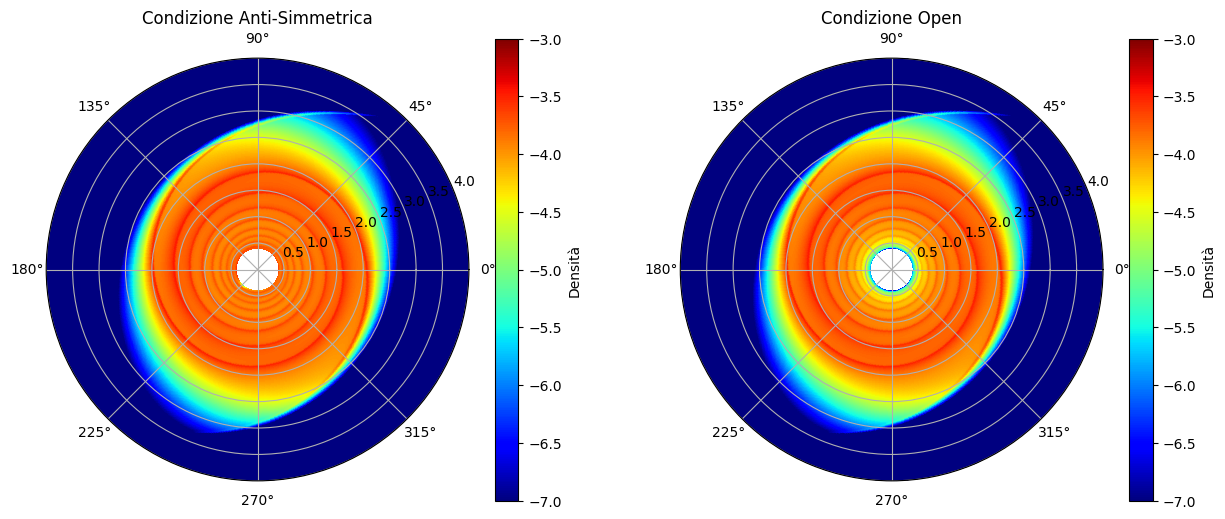

In [47]:
fig = plt.figure(figsize=(15, 6))

# Creare una griglia di valori R e Theta
theta = np.linspace(-np.pi, np.pi, 1152)
r = np.linspace(0.4, 4, 384)
Theta, R = np.meshgrid(theta, r)

#Grafico 1
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
rho = np.fromfile("InnerBound/Anti/gasdens40.dat").reshape(384,1152)
cax = ax1.pcolormesh(Theta, R, np.log10(rho), cmap='jet', vmin = -7, vmax =-3)
ax1.set_title('Condizione Anti-Simmetrica')
plt.colorbar(cax, label='Densità')
ax1.set_rmin(0)
ax1.set_rmax(4)

#Grafico 2
ax2 = fig.add_subplot(1, 2, 2, projection='polar')
rho = np.fromfile("InnerBound/Open/gasdens40.dat").reshape(384,1152)
cax = ax2.pcolormesh(Theta, R, np.log10(rho), cmap='jet', vmin = -7, vmax =-3)
ax2.set_title('Condizione Open')
plt.colorbar(cax, label='Densità')
ax2.set_rmin(0)
ax2.set_rmax(4)

plt.show()

### Dimensioni dei raggi

Per determinare le dimensioni dei raggi medio sui vari output dalla decima orbita in poi: lavoro quindi con gli output dal ventesimo al quarantesimo. Come criterio utilizzo il 99.9% della massa totale del disco:

In [48]:
nomi = np.array(['Anti', 'Open'])
cond = np.array(['Anti-sym', 'Open'])

for h in range(0, 2):
    rag = np.zeros(21)

    for k in range(0, 21):
        #Importo la densità considerata
        rho = np.fromfile("InnerBound/"+nomi[h]+"/gasdens"+str(20 + k)+".dat").reshape(384,1152)
        massa = 0

        for i in range(0,384):
            #Calcolo area della singola sezione
            area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
            area = area/1152

            for j in range(0, 1152):
                massa += area * rho[i, j]

        #Controllo ora dove ottengo il 90% della massa
        appo = 0
        raggio = 0

        for i in range(0,384):
            #Calcolo area della singola sezione
            area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
            area = area/1152

            raggio = (i+1)*(4-0.4)/384 + 0.4

            for j in range(0, 1152):
                appo += area * rho[i, j]
    
            if appo >= 0.999*massa:
                rag[k] = raggio
                break

    med = 0
    for i in range(0, len(rag)):
        med += rag[i]
    print('Il raggio di troncamento del disco con condizioni: ' + cond[h] + ' è pari a: ' + str(round(med/len(rag), 3)))

Il raggio di troncamento del disco con condizioni: Anti-sym è pari a: 2.844
Il raggio di troncamento del disco con condizioni: Open è pari a: 2.853


<center>

# <span style="color:blue;">Condizione esterna: anti-simmetrica o aperta?</span>

<center>

Voglio confrontare l'efficienza computazionale di queste due tipologie di condizioni al contorno per la velocità radiale: anti-simmetrica oppure aperta. La condizione interna è sempre anti-simmetrica. Lavoro su 30 cores in modo tale che le simulazioni abbiano rispettivamente durata: .

### Output finale

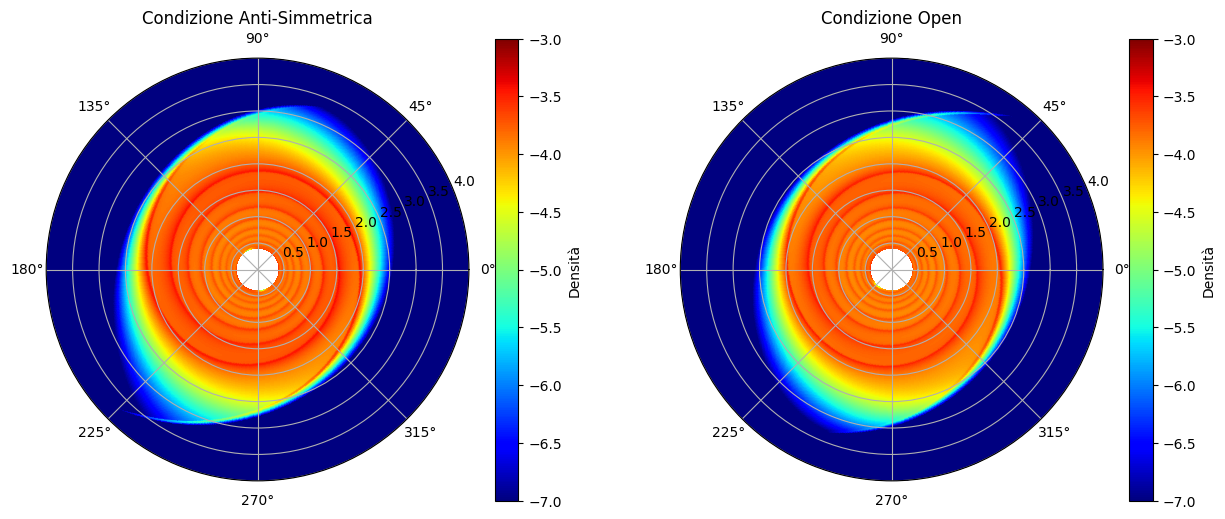

In [49]:
fig = plt.figure(figsize=(15, 6))

# Creare una griglia di valori R e Theta
theta = np.linspace(-np.pi, np.pi, 1152)
r = np.linspace(0.4, 4, 384)
Theta, R = np.meshgrid(theta, r)

#Grafico 1
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
rho = np.fromfile("OuterBound/Anti/gasdens39.dat").reshape(384,1152)
cax = ax1.pcolormesh(Theta, R, np.log10(rho), cmap='jet', vmin = -7, vmax =-3)
ax1.set_title('Condizione Anti-Simmetrica')
plt.colorbar(cax, label='Densità')
ax1.set_rmin(0)
ax1.set_rmax(4)

#Grafico 2
ax2 = fig.add_subplot(1, 2, 2, projection='polar')
rho = np.fromfile("OuterBound/Open/gasdens40.dat").reshape(384,1152)
cax = ax2.pcolormesh(Theta, R, np.log10(rho), cmap='jet', vmin = -7, vmax =-3)
ax2.set_title('Condizione Open')
plt.colorbar(cax, label='Densità')
ax2.set_rmin(0)
ax2.set_rmax(4)

plt.show()

### Raggi

In [50]:
nomi = np.array(['Anti', 'Open'])
cond = np.array(['Anti-sym', 'Open'])
num = np.array([20, 21])

for h in range(0, 2):
    rag = np.zeros(num[h])

    for k in range(0, num[h]):
        #Importo la densità considerata
        rho = np.fromfile("OuterBound/"+nomi[h]+"/gasdens"+str(20 + k)+".dat").reshape(384,1152)
        massa = 0

        for i in range(0,384):
            #Calcolo area della singola sezione
            area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
            area = area/1152

            for j in range(0, 1152):
                massa += area * rho[i, j]

        #Controllo ora dove ottengo il 90% della massa
        appo = 0
        raggio = 0

        for i in range(0,384):
            #Calcolo area della singola sezione
            area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
            area = area/1152

            raggio = (i+1)*(4-0.4)/384 + 0.4

            for j in range(0, 1152):
                appo += area * rho[i, j]
    
            if appo >= 0.999*massa:
                rag[k] = raggio
                break

    med = 0
    for i in range(0, len(rag)):
        med += rag[i]
    print('Il raggio di troncamento del disco con condizioni: ' + cond[h] + ' è pari a: ' + str(round(med/len(rag), 3)))

Il raggio di troncamento del disco con condizioni: Anti-sym è pari a: 2.856
Il raggio di troncamento del disco con condizioni: Open è pari a: 2.844


<center>

# <span style="color:blue;">Completiamo il quadro: tutte le possibili combinazioni</span>

<center>

Tutte le simulazioni test che ho fatto fino ad ora sono state fatte evolvere su 30 processori. Riassumo i differenti tempi di esecuzione in dipendenza delle differenti condizioni al contorno applicate:

- Open-Open: 1 ora 34 minuti 56 secondi

- Anti-Open: 1 ora 41 minuti 13 secondi

- Open-Anti: 2 ore circa (36 outputs)

- Anti-Anti: 2 ore circa (39 outputs)

### Ultimo output

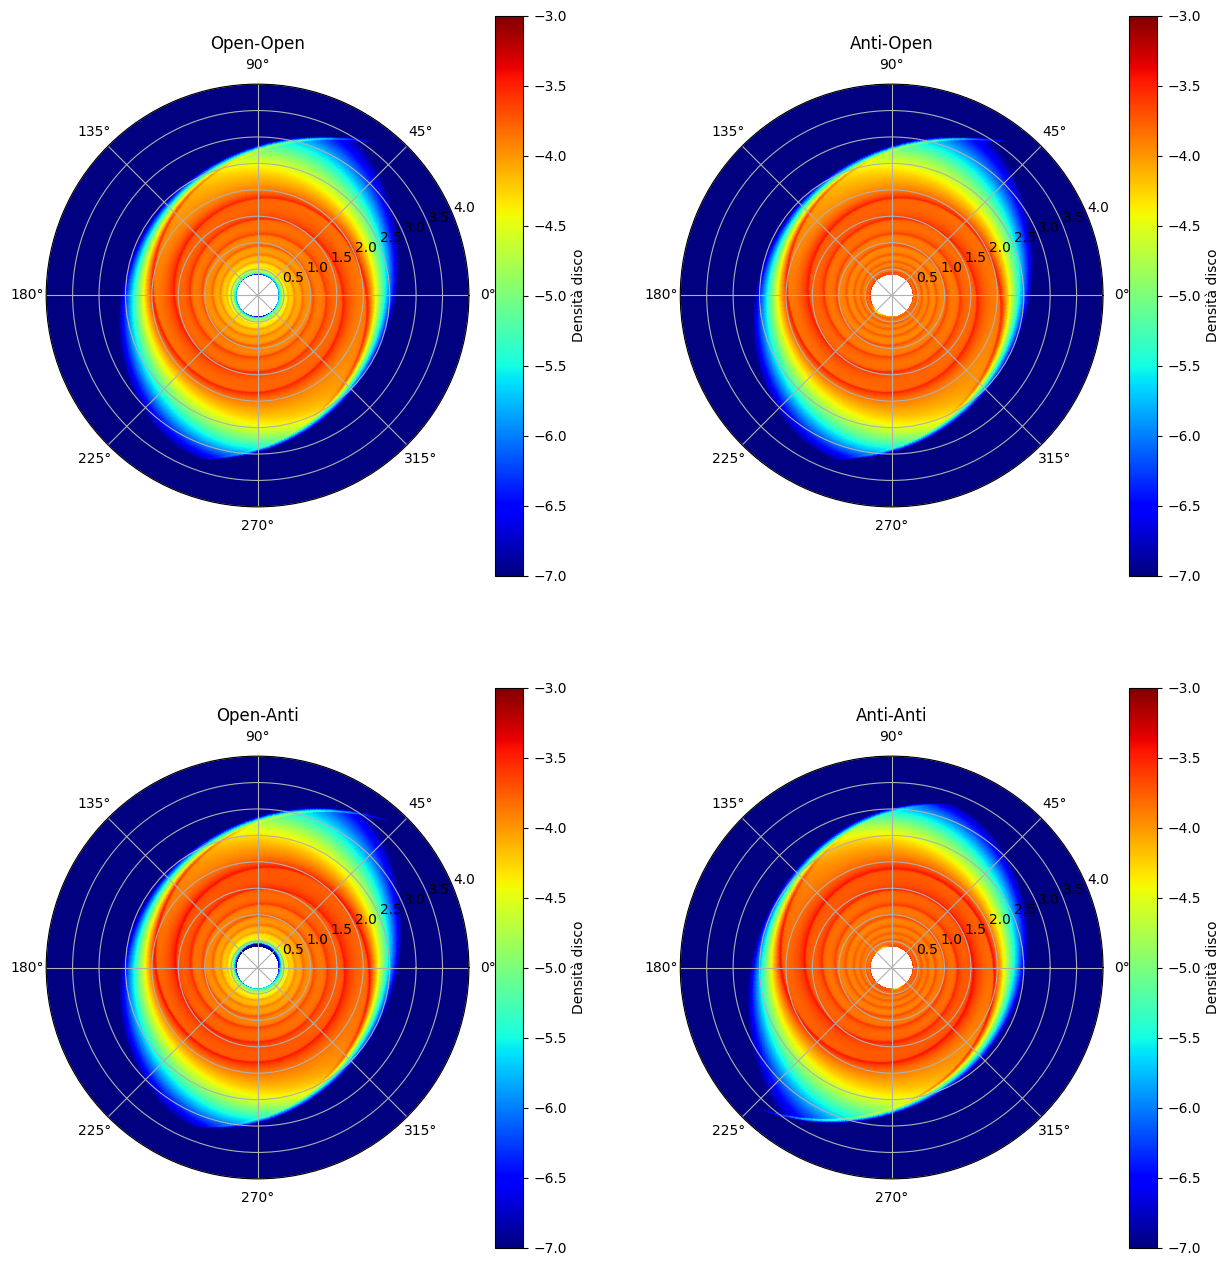

In [51]:
nomi = np.array(['OpenOpen', 'AntiOpen','OpenAnti', 'AntiAnti'])
titoli = np.array(['Open-Open', 'Anti-Open', 'Open-Anti', 'Anti-Anti'])
num = np.array([40, 40, 36, 39])

# Creare una griglia di valori R e Theta
theta = np.linspace(-np.pi, np.pi, 1152)
r = np.linspace(0.4, 4, 384)
Theta, R = np.meshgrid(theta, r)

# Creare una figura con più grafici polari
fig, axs = plt.subplots(2, 2, figsize=(15, 16), subplot_kw={'projection': 'polar'})

for i in range(0, 2):
    for j in range(0, 2):
        ax = axs[i, j]

        #Valori assunti dalla funzione
        rho = np.fromfile('AllBound/'+nomi[2*i+j]+'/gasdens'+str(num[2*i+j])+'.dat').reshape(384, 1152)

        # Disegnare il grafico polare
        cax = ax.pcolormesh(Theta, R, np.log10(rho), cmap='jet', vmin = -7, vmax =-3)
        plt.colorbar(cax, label='Densità disco')
        ax.set_rmin(0)
        ax.set_rmax(4)
        ax.set_title(titoli[2*i+j])
    
    

# Mostrare la figura con i grafici polari multipli
plt.show()

### Raggi

In [52]:
nomi = np.array(['OpenOpen', 'AntiOpen','OpenAnti', 'AntiAnti'])
titoli = np.array(['Open-Open', 'Anti-Open', 'Open-Anti', 'Anti-Anti'])
num = np.array([21, 21, 17, 20])

for h in range(0, 4):
    rag = np.zeros(num[h])

    for k in range(0, num[h]):
        #Importo la densità considerata
        rho = np.fromfile("AllBound/"+nomi[h]+"/gasdens"+str(20 + k)+".dat").reshape(384,1152)
        massa = 0

        for i in range(0,384):
            #Calcolo area della singola sezione
            area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
            area = area/1152

            for j in range(0, 1152):
                massa += area * rho[i, j]

        #Controllo ora dove ottengo il 90% della massa
        appo = 0
        raggio = 0

        for i in range(0,384):
            #Calcolo area della singola sezione
            area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
            area = area/1152

            raggio = (i+1)*(4-0.4)/384 + 0.4

            for j in range(0, 1152):
                appo += area * rho[i, j]
    
            if appo >= 0.999*massa:
                rag[k] = raggio
                break

    med = 0
    for i in range(0, len(rag)):
        med += rag[i]
    print('Il raggio di troncamento del disco con condizioni: ' + titoli[h] + ' è pari a: ' + str(round(med/len(rag), 3)))

Il raggio di troncamento del disco con condizioni: Open-Open è pari a: 2.853
Il raggio di troncamento del disco con condizioni: Anti-Open è pari a: 2.844
Il raggio di troncamento del disco con condizioni: Open-Anti è pari a: 2.866
Il raggio di troncamento del disco con condizioni: Anti-Anti è pari a: 2.856


### Masse

Abbiamo testato alcune possibili condizioni alle frontiere, alcune delle quali garantiscono l'uscita di massa dalla griglia. Andiamo ora a valutare quali siano le masse finali dei dischi e come vada a variare la massa dei dischi stessi in funzione del numero di output (ossia durante l'evoluzione del sistema).

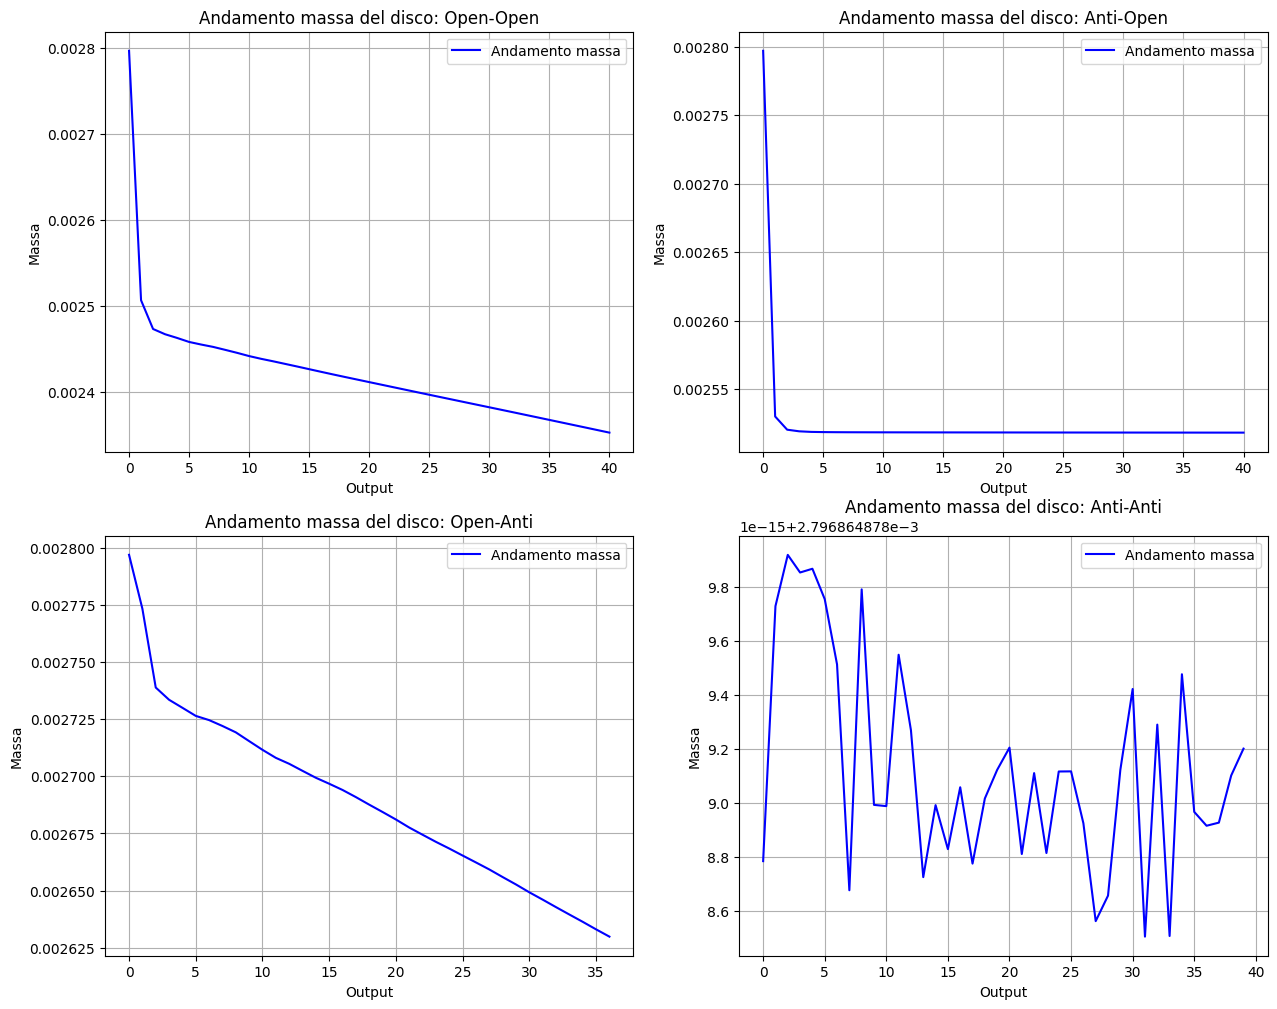

In [78]:
nomi = np.array(['OpenOpen', 'AntiOpen','OpenAnti', 'AntiAnti'])
titoli = np.array(['Open-Open', 'Anti-Open', 'Open-Anti', 'Anti-Anti'])
num = np.array([41, 41, 37, 40]) #Voglio considerare tutti gli output

# Creare una figura con più grafici polari
fig, axs = plt.subplots(2, 2, figsize=(15, 12))


for h in range(0, 4):
    ax = axs[h // 2, h % 2]
    #Asse x grafici
    x = np.zeros(num[h])
    for i in range(0, len(x)):
        x[i] = i
    #Asse y
    mas_dis = np.zeros(num[h])

    for k in range(0, num[h]):
        rho = np.fromfile("AllBound/"+nomi[h]+"/gasdens" + str(k) + ".dat").reshape(384,1152)

        massa = 0
        for i in range(0,384):
            #Calcolo area della singola sezione
            area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
            area = area/1152

            for j in range(0, 1152):
                massa += area * rho[i, j]
        
        mas_dis[k] = massa
    
    ax.plot(x, mas_dis, color = 'blue', label = 'Andamento massa')
    ax.set_title('Andamento massa del disco: ' + titoli[h])
    ax.set_xlabel('Output')
    ax.set_ylabel('Massa')
    ax.grid(True)
    ax.legend()

plt.show() 

<center>

# <span style="color:blue;">Run test: 50 orbite</span>

<center>

Voglio capire quante simulazioni posso effettuare con il monteore a me assegnato. Lavoro con il setup che vorrei utilizzare per le simulazioni che poi entreranno nella mia tesi, ossia:

- Inner boundary condition: Anti-symmetric

- Outer boundary condition: Open

<center>

## Disco circum-secondario: q = 0.33, e = 0.0

<center>

Effettuo questa simulazione su 20 processori: la durata è di 5 ore 34 minuti e 15 secondi.

### Output finale

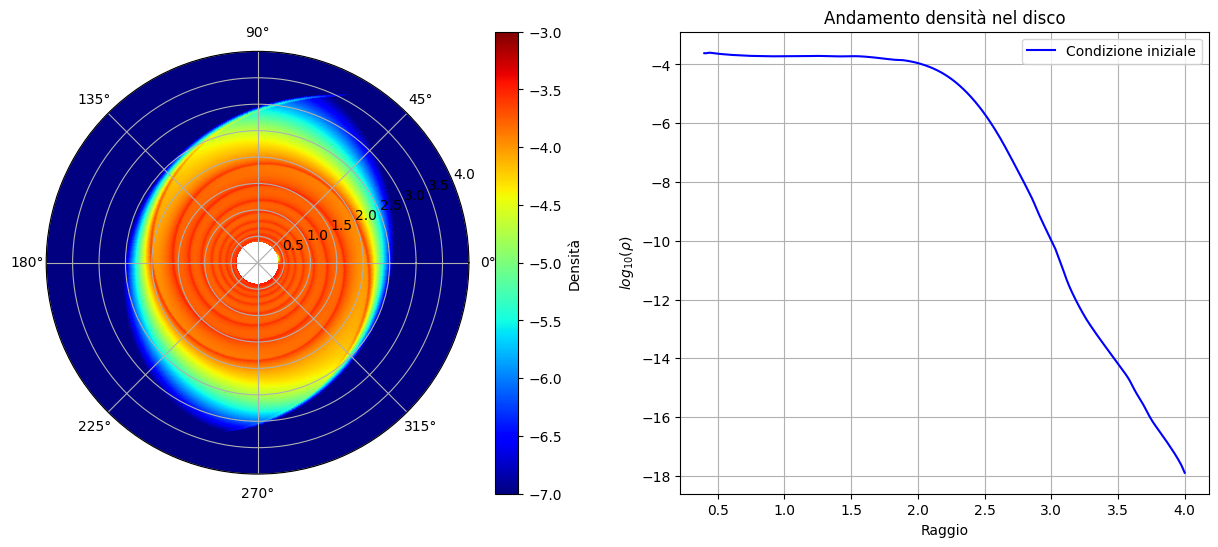

In [79]:
fig = plt.figure(figsize=(15, 6))

# Creare una griglia di valori R e Theta
theta = np.linspace(-np.pi, np.pi, 1152)
r = np.linspace(0.4, 4, 384)
Theta, R = np.meshgrid(theta, r)

#Grafico 1
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
rho = np.fromfile("50orbite/NoEcc/gasdens100.dat").reshape(384,1152)
cax = ax1.pcolormesh(Theta, R, np.log10(rho), cmap='jet', vmin = -7, vmax =-3)
plt.colorbar(cax, label='Densità')
ax1.set_rmin(0)
ax1.set_rmax(4)


#Grafico 2
ax2 = fig.add_subplot(1, 2, 2)
den_sup = np.zeros(384)

#Determino andamento della densità superficiale
for i in range(0, 384):
    appo = 0
    for j in range(0, 1152):
        appo += np.log10(rho[i, j])

    appo = appo/1152
    den_sup[i] = appo

ax2.plot(np.linspace(0.4, 4, 384), den_sup[:], color = 'blue', label = 'Condizione iniziale')
ax2.set_title('Andamento densità nel disco')
ax2.set_xlabel('Raggio')
ax2.set_ylabel(r'$log_{10}(\rho)$')
ax2.grid(True)
ax2.legend()

plt.show()

### Raggio

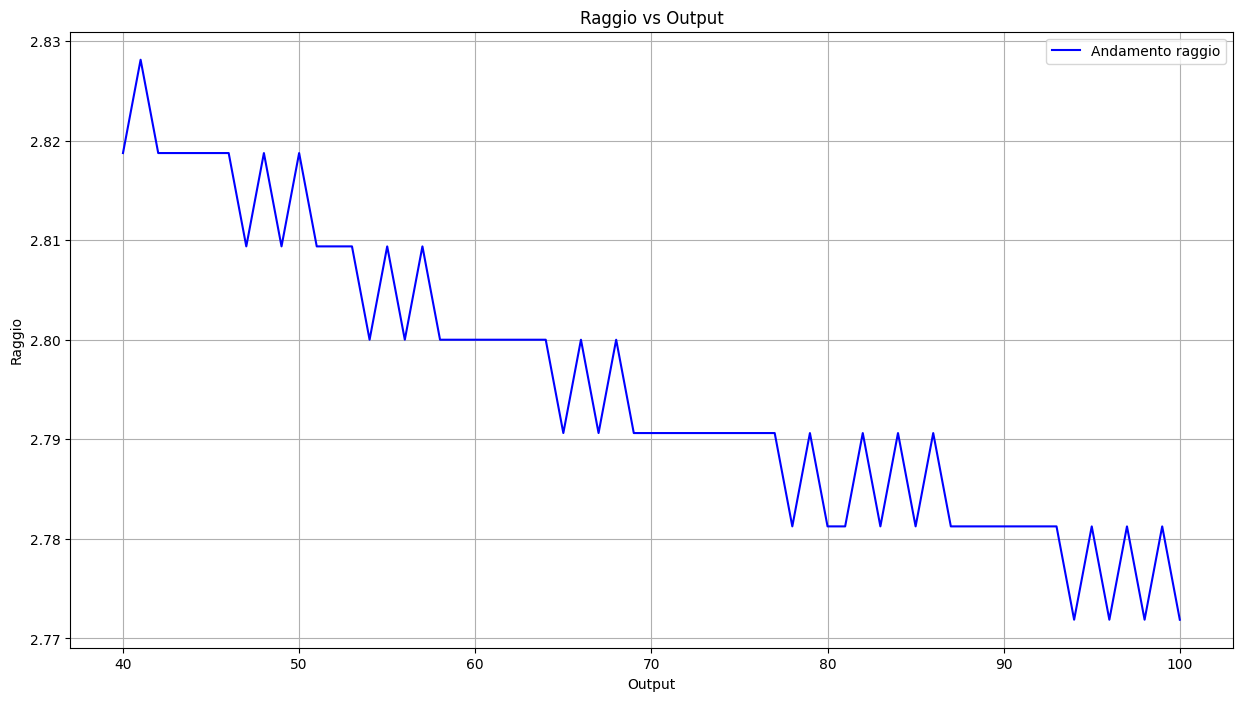

Il raggio di troncamento del disco è pari a: 2.795


In [97]:
rag = np.zeros(61)

for k in range(0, 61):
    #Importo la densità considerata
    rho = np.fromfile("50orbite/NoEcc/gasdens" + str(40 + k) + ".dat").reshape(384,1152)
    massa = 0

    for i in range(0,384):
        #Calcolo area della singola sezione
        area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
        area = area/1152

        for j in range(0, 1152):
            massa += area * rho[i, j]

    #Controllo ora dove ottengo il 99% della massa
    appo = 0
    raggio = 0

    for i in range(0,384):
        #Calcolo area della singola sezione
        area = np.pi * (pow(((i+1)*(4-0.4)/384 + 0.4),2)-pow((i*(4-0.4)/384 + 0.4),2))
        area = area/1152

        raggio = (i+1)*(4-0.4)/384 + 0.4

        for j in range(0, 1152):
            appo += area * rho[i, j]
    
        if appo >= 0.999*massa:
            rag[k] = raggio
            break

med = 0
for i in range(0, len(rag)):
    med += rag[i]

x = np.zeros(61)
for i in range(0, len(x)):
    x[i] = i + 40

plt.figure(figsize=(15, 8))
plt.plot(x, rag, color = 'blue', label = 'Andamento raggio')
plt.xlabel('Output')
plt.ylabel('Raggio')
plt.title('Raggio vs Output')
plt.grid(True)
plt.legend()
plt.show()

print('Il raggio di troncamento del disco è pari a: ' + str(round(med/(len(rag)), 3)))

<center>

## Disco circum-secondario: q = 0.33, e = 0.6

<center>

### Output finale

Effettuo questa simulazione su 20 processori: il tempo di esecuzione è 15 ore 34 minuti e 48 secondi.

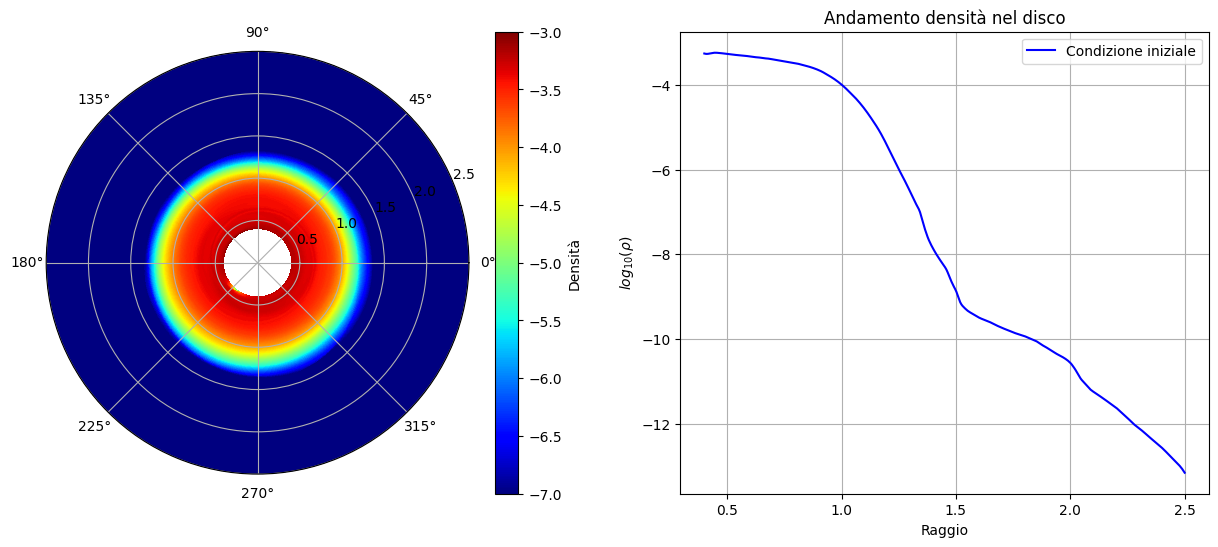

In [92]:
fig = plt.figure(figsize=(15, 6))

# Creare una griglia di valori R e Theta
theta = np.linspace(-np.pi, np.pi, 1152)
r = np.linspace(0.4, 2.5, 384)
Theta, R = np.meshgrid(theta, r)

#Grafico 1
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
rho = np.fromfile("50orbite/Ecc/gasdens100.dat").reshape(384,1152)
cax = ax1.pcolormesh(Theta, R, np.log10(rho), cmap='jet', vmin = -7, vmax =-3)
plt.colorbar(cax, label='Densità')
ax1.set_rmin(0)
ax1.set_rmax(2.5)


#Grafico 2
ax2 = fig.add_subplot(1, 2, 2)
den_sup = np.zeros(384)

#Determino andamento della densità superficiale
for i in range(0, 384):
    appo = 0
    for j in range(0, 1152):
        appo += np.log10(rho[i, j])

    appo = appo/1152
    den_sup[i] = appo

ax2.plot(np.linspace(0.4, 2.5, 384), den_sup[:], color = 'blue', label = 'Condizione iniziale')
ax2.set_title('Andamento densità nel disco')
ax2.set_xlabel('Raggio')
ax2.set_ylabel(r'$log_{10}(\rho)$')
ax2.grid(True)
ax2.legend()

plt.show()

### Raggio

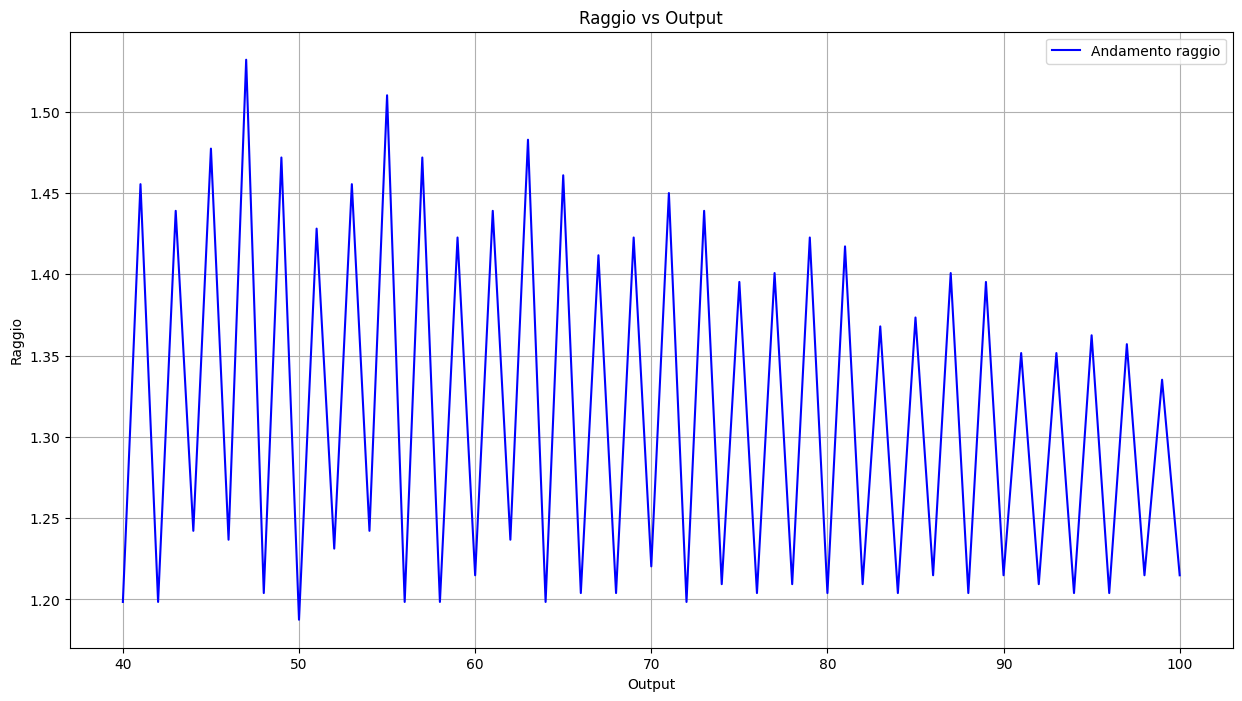

Il raggio di troncamento del disco è pari a: 0.11 a


In [98]:
rag = np.zeros(61)

for k in range(0, 61):
    #Importo la densità considerata
    rho = np.fromfile("50orbite/Ecc/gasdens" + str(40 + k) + ".dat").reshape(384,1152)
    massa = 0

    for i in range(0,384):
        #Calcolo area della singola sezione
        area = np.pi * (pow(((i+1)*(2.5-0.4)/384 + 0.4),2)-pow((i*(2.5-0.4)/384 + 0.4),2))
        area = area/1152

        for j in range(0, 1152):
            massa += area * rho[i, j]

    #Controllo ora dove ottengo il 99% della massa
    appo = 0
    raggio = 0

    for i in range(0,384):
        #Calcolo area della singola sezione
        area = np.pi * (pow(((i+1)*(2.5-0.4)/384 + 0.4),2)-pow((i*(2.5-0.4)/384 + 0.4),2))
        area = area/1152

        raggio = (i+1)*(2.5-0.4)/384 + 0.4

        for j in range(0, 1152):
            appo += area * rho[i, j]
    
        if appo >= 0.999*massa:
            rag[k] = raggio
            break

med = 0
for i in range(0, len(rag)):
    med += rag[i]

x = np.zeros(61)
for i in range(0, len(x)):
    x[i] = i + 40

plt.figure(figsize=(15, 8))
plt.plot(x, rag, color = 'blue', label = 'Andamento raggio')
plt.xlabel('Output')
plt.ylabel('Raggio')
plt.title('Raggio vs Output')
plt.grid(True)
plt.legend()
plt.show()

print('Il raggio di troncamento del disco è pari a: ' + str(round(med/(len(rag))/12, 3)) + ' a')